In [2]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize

from statsmodels.tsa.holtwinters import ExponentialSmoothing

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

## Данные

In [3]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)
passengers.columns = ["y"]

In [4]:
passengers.head()

,y
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


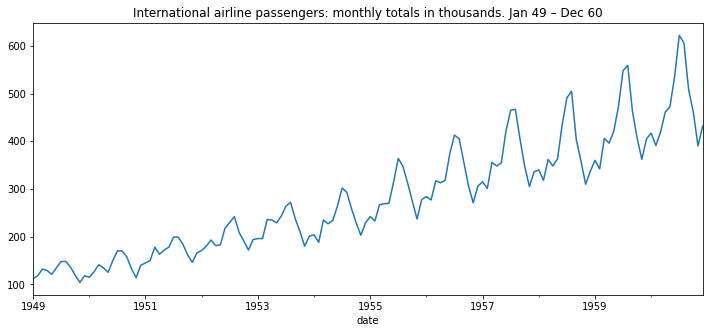

In [5]:
passengers["y"].plot(figsize=(12,5))
plt.title("International airline passengers: monthly totals in thousands. Jan 49 – Dec 60")
plt.show()

In [6]:
s = 12

passlen = len(passengers)
phi = [np.sin((2*np.pi*(i-1))/s) for i in range(1, passlen + 1)]
psi = [np.cos((2*np.pi*(i-1))/s) for i in range(1, passlen + 1)]
x1 = list(range(1, len(passengers) + 1))

# passengers["const"] = 1
passengers["x1"] = x1
passengers["phi"] = phi
passengers["psi"] = psi

In [7]:
passengers.head()

,y,x1,phi,psi
date,,,,
1949-01-01,112,1,0.000000,1.000000e+00
1949-02-01,118,2,0.500000,8.660254e-01
1949-03-01,132,3,0.866025,5.000000e-01
1949-04-01,129,4,1.000000,6.123234e-17
1949-05-01,121,5,0.866025,-5.000000e-01


## Подбор параметров

In [8]:
def mse(data, theta0, theta1, beta1, beta2):
    return np.mean((data["y"] - (theta0 + theta1*data["x1"] + beta1*data["phi"] + beta2*data["psi"]))**2)

In [9]:
opfunc = lambda x: mse(passengers, x[0], x[1], x[2], x[3])

optimization = minimize(opfunc, (0, 0, 0, 0))

print(optimization)
theta0, theta1, beta1, beta2 = optimization.x

      fun: 1042.0664148569094
 hess_inv: array([[ 2.16199880e+00, -2.26887084e-02,  1.13830718e-01,
         5.84308704e-03],
       [-2.26887084e-02,  3.09821489e-04, -9.88384656e-04,
         3.76018230e-05],
       [ 1.13830718e-01, -9.88384656e-04,  9.68934013e-01,
         8.17598521e-02],
       [ 5.84308704e-03,  3.76018230e-05,  8.17598521e-02,
         1.00643150e+00]])
      jac: array([0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 105
      nit: 12
     njev: 21
   status: 0
  success: True
        x: array([ 88.18246327,   2.64987789,   5.42625932, -45.49952248])


In [10]:
print(f"MSE: {optimization.fun}")

MSE: 1042.0664148569094


In [11]:
approx = theta0 + theta1*passengers["x1"] + beta1*passengers["phi"] + beta2*passengers["psi"]

## Аппроксимация

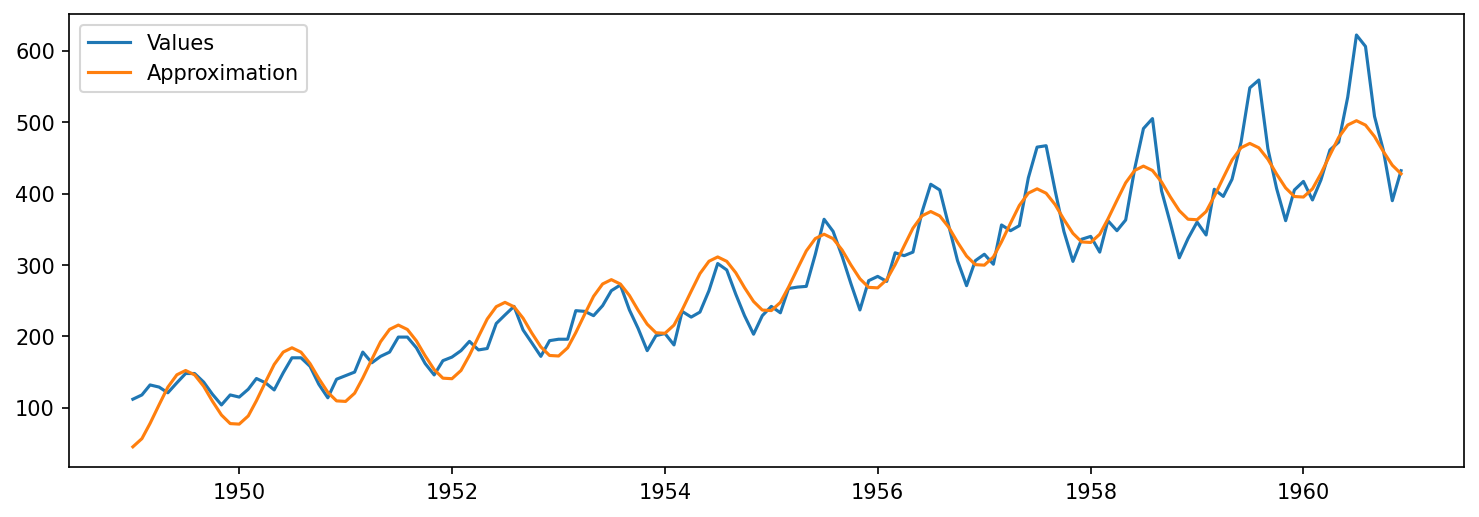

In [12]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(passengers["y"], label="Values")
plt.plot(approx, label="Approximation")
plt.legend()
plt.show()

## Прогноз

In [13]:
holt_winters_trend = ExponentialSmoothing(approx, initialization_method="estimated",
                                          trend="add", seasonal="add").fit()

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [14]:
start = approx.index[-1] + pd.DateOffset(months=1)
end = start + pd.DateOffset(months=35)
start, end

(Timestamp('1961-01-01 00:00:00'), Timestamp('1963-12-01 00:00:00'))

In [15]:
holt_winters_forecast = holt_winters_trend.predict(start=start, end=end)

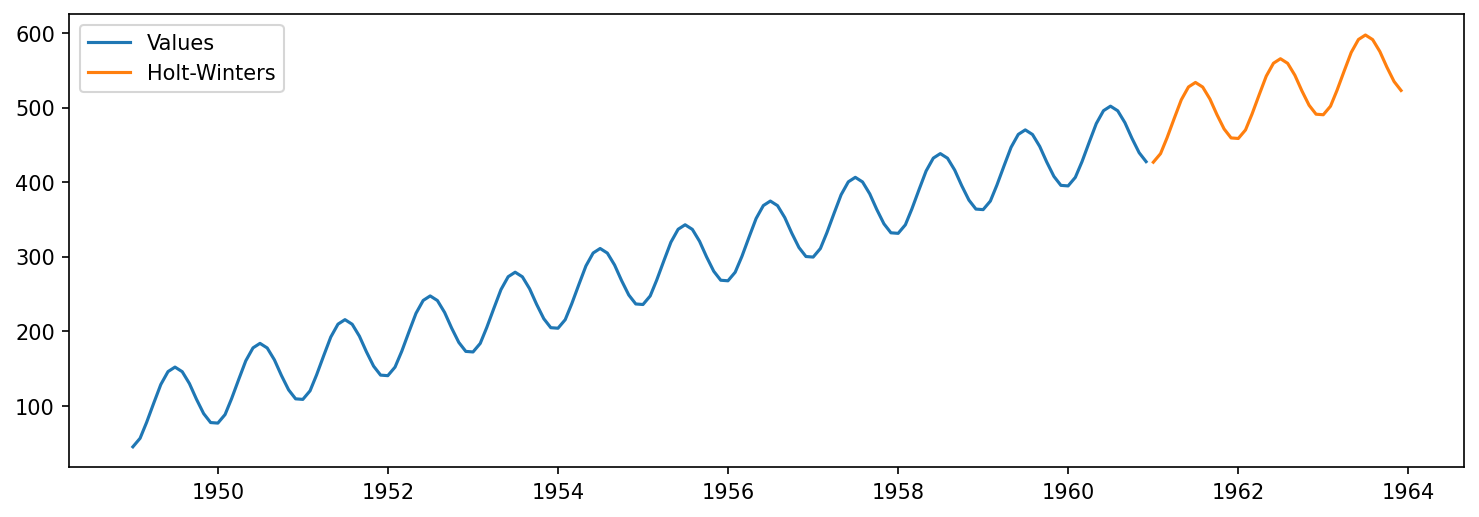

In [16]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(approx, label="Values")
plt.plot(holt_winters_forecast, label="Holt-Winters")
plt.legend(loc="upper left")
plt.show()

## Анализ остатков

In [17]:
res = passengers["y"] - approx

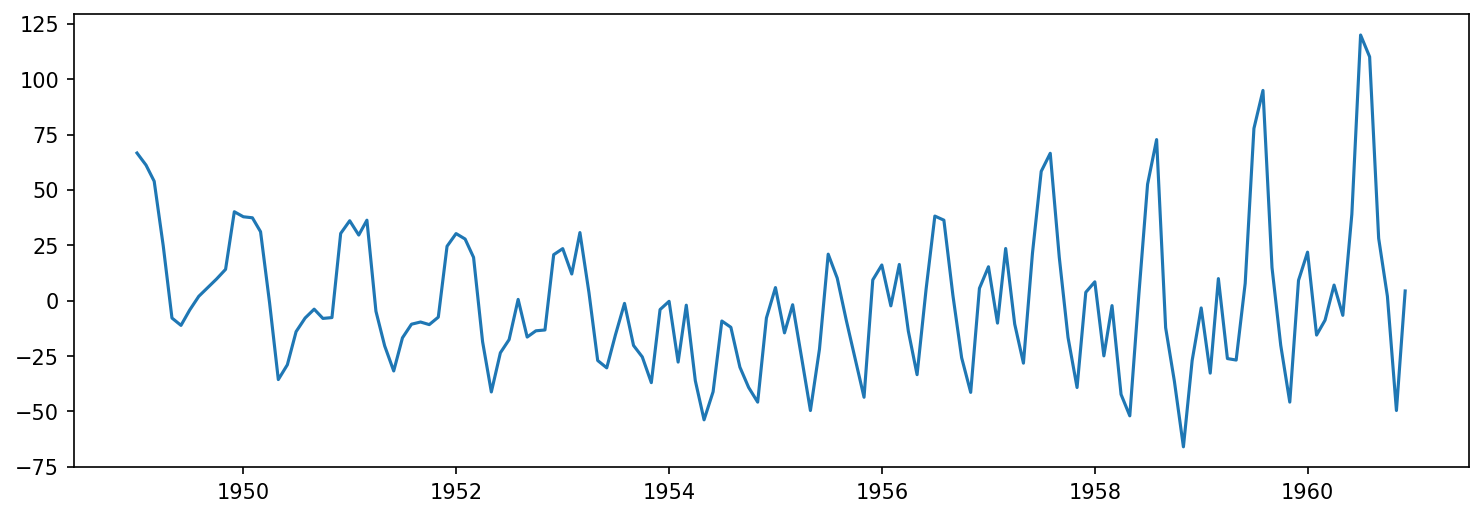

In [18]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(res)
plt.show()

## Новые критерии

In [74]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)

In [75]:
df = pd.get_dummies(passengers.index.month).set_index(passengers.index)

In [76]:
df["y"] = passengers["num_passengers"]

In [77]:
df.columns = [f"x{i}"for i in range(1, 13)] + ["y"]

In [78]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y
date,,,,,,,,,,,,,
1949-01-01,1,0,0,0,0,0,0,0,0,0,0,0,112
1949-02-01,0,1,0,0,0,0,0,0,0,0,0,0,118
1949-03-01,0,0,1,0,0,0,0,0,0,0,0,0,132
1949-04-01,0,0,0,1,0,0,0,0,0,0,0,0,129
1949-05-01,0,0,0,0,1,0,0,0,0,0,0,0,121


In [79]:
def mse(data, var):
    return np.mean((data["y"] - (var[0] + sum(var[i]*data[f"x{i}"] for i in range(1, 13))))**2)

In [81]:
opfunc = lambda x: mse(df, x)

optimization = minimize(opfunc, [0 for i in range(13)])

print(optimization)
var = optimization.x

      fun: 12775.429976902138
 hess_inv: array([[ 0.31128515, -0.08161293, -0.16870722, -0.17325626, -0.06430165,
        -0.03408614, -0.04836477,  0.09149845,  0.09031629,  0.01021322,
        -0.02368362, -0.16824265, -0.05067094],
       [-0.08161293,  0.96845585,  0.07455139, -0.01906488, -0.11474428,
        -0.17696707, -0.15702878, -0.56122331, -0.22417418, -0.09896947,
         0.03497254,  0.01910369,  0.20720306],
       [-0.16870722,  0.07455139,  0.51158377, -0.12511792,  0.07067815,
         0.04395767,  0.0770514 , -0.03688281, -0.10731194, -0.00708394,
         0.00746549, -0.24469084, -0.01655676],
       [-0.17325626, -0.01906488, -0.12511792,  0.48338575, -0.027044  ,
        -0.07036762, -0.03289364, -0.20592817, -0.10096404, -0.0239266 ,
         0.00195456,  0.32459247,  0.0512214 ],
       [-0.06430165, -0.11474428,  0.07067815, -0.027044  ,  0.58446468,
        -0.13941888,  0.27359079, -0.20461736, -0.0340417 , -0.01716046,
         0.29224011, -0.01286545,  0.

In [82]:
approx = var[0] + sum(var[i]*df[f"x{i}"] for i in range(1, 13))

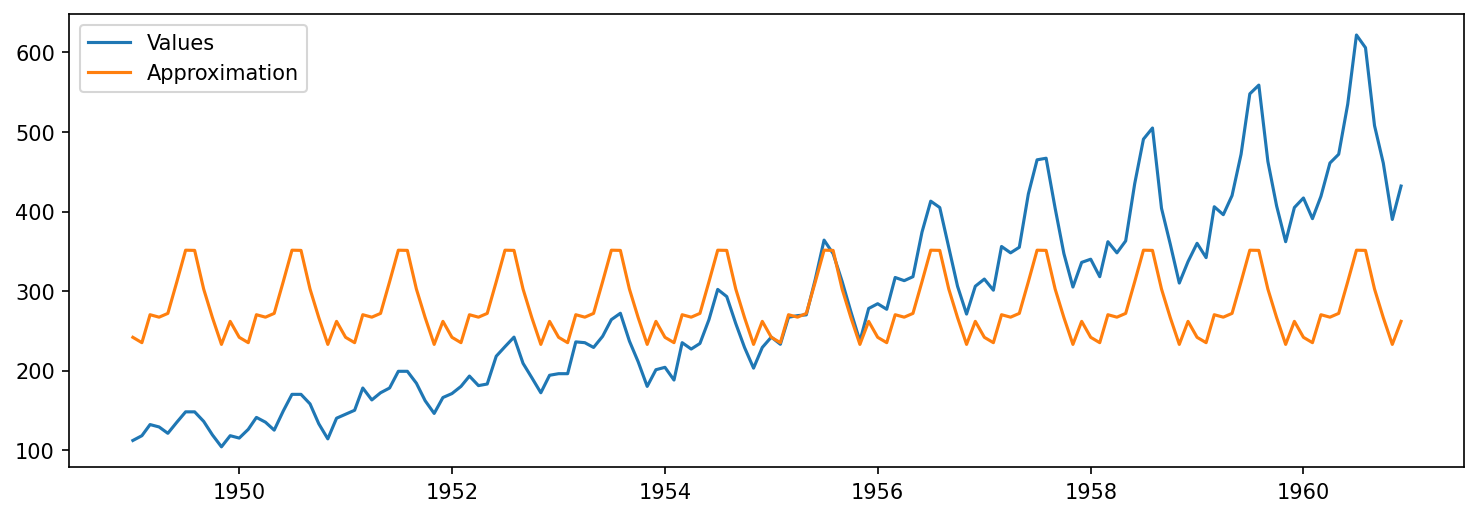

In [83]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(df["y"], label="Values")
plt.plot(approx, label="Approximation")
plt.legend()
plt.show()

In [84]:
holt_winters_trend = ExponentialSmoothing(approx, initialization_method="estimated",
                                          trend="add", seasonal="add").fit()

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [85]:
holt_winters_forecast = holt_winters_trend.predict(start=start, end=end)

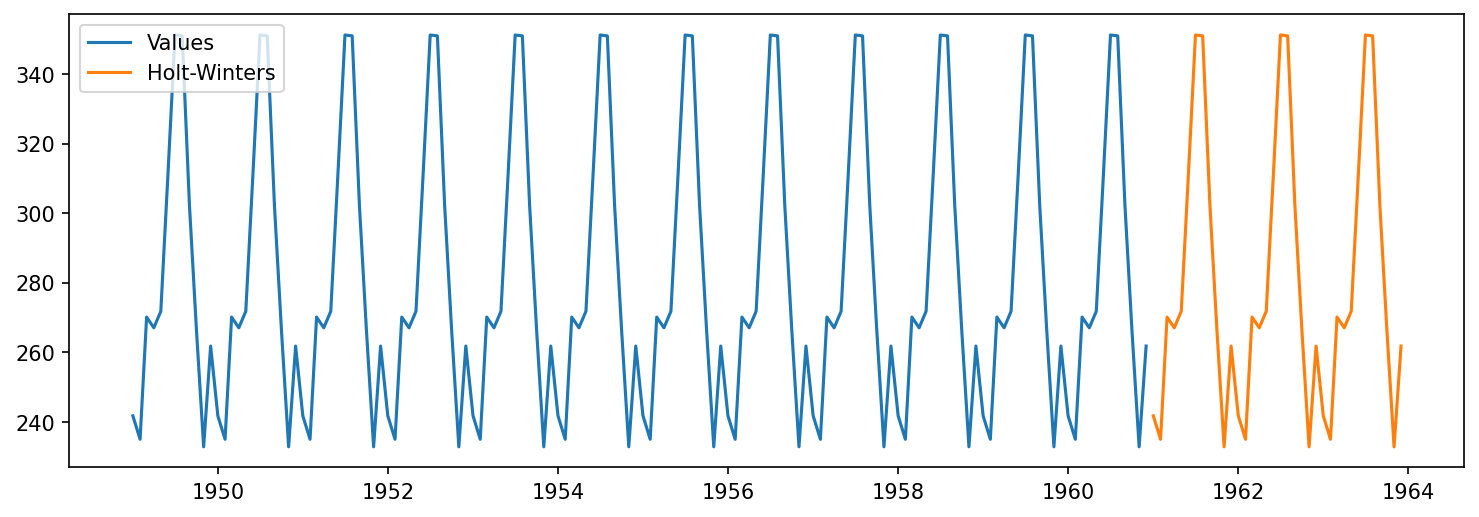

In [86]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(approx, label="Values")
plt.plot(holt_winters_forecast, label="Holt-Winters")
plt.legend(loc="upper left")
plt.show()